# BERT

In [1]:
target_dir = '../backend/chatbot/'

In [2]:
from transformers import TrainerCallback

class AlignedLossCallback(TrainerCallback):
    def __init__(self):
        self.train_steps = []
        self.eval_steps = []
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        logs = logs or {}
        # Log training loss
        if "loss" in logs:
            self.train_steps.append(state.global_step)
            self.train_losses.append(logs["loss"])
        # Log evaluation loss
        if "eval_loss" in logs:
            self.eval_steps.append(state.global_step)
            self.eval_losses.append(logs["eval_loss"])

aligned_loss_callback = AlignedLossCallback()

/home/harshit/IITH/Sem7/CyberSecurityAndAI/project/cyber_security_project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datasets import Dataset
import pandas as pd
from transformers import BertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch

# Load dataset
# datafile = '../data/Bitext.csv'
datafile = './data/bert_input.csv'
df = pd.read_csv(datafile)
df = df[['instruction', 'intent']]
print(len(df))

# Convert to Hugging Face dataset
intent_dataset = Dataset.from_pandas(df)

# get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(example):
    return tokenizer(example['instruction'], padding='max_length', truncation=True, max_length=128)

# Apply tokenization to the dataset
intent_dataset = intent_dataset.map(tokenize_function, remove_columns=["instruction"])

# Map 'intent' to numerical labels
intent_labels = {intent: idx for idx, intent in enumerate(df['intent'].unique())}
intent_dataset = intent_dataset.map(lambda x: {'labels': intent_labels[x['intent']]})

# Number of intents
num_intents = len(df['intent'].unique())
print(num_intents)

# Load DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_intents)

# Data collator (use for sequence classification, handles padding)
data_collator = DataCollatorWithPadding(tokenizer, padding='max_length', max_length=128)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./intent_model',
    save_strategy="steps",
    save_steps=500,  # Save model every 500 steps
    logging_dir='./logs',
    logging_steps=10,  # Log training loss every 500 steps
    evaluation_strategy="steps",  # Evaluate every 500 steps
    eval_steps=10,  # Perform evaluation every 500 steps
    save_total_limit=2,
    num_train_epochs=50,
    per_device_train_batch_size=8,
    disable_tqdm=False,
    load_best_model_at_end=True,
)

# split dataset
# Initial train/test split
train_val_split = intent_dataset.train_test_split(test_size=0.1)
intent_dataset_train = train_val_split['train']
intent_dataset_val = train_val_split['test']

# Further split the training set into train and test sets
train_test_split = intent_dataset_train.train_test_split(test_size=0.1)
intent_dataset_train = train_test_split['train']
intent_dataset_test = train_test_split['test']

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=intent_dataset_train,
    eval_dataset=intent_dataset_val,
    data_collator=data_collator,
    callbacks=[aligned_loss_callback]
)

# Train the model with tqdm progress bar
trainer.train()
tokenizer.save_pretrained('./intent_model')

2024-12-01 00:07:06.232812: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 00:07:06.242379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732991826.253413   29223 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732991826.256517   29223 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 00:07:06.269643: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

104
Using device: cuda


Map: 100%|██████████| 104/104 [00:00<00:00, 20525.49 examples/s]


7


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/harshit/IITH/Sem7/CyberSecurityAndAI/project/cyber_security_project/venv/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  2%|▏         | 10/550 [00:01<00:45, 11.92it/s]

{'loss': 1.8542, 'grad_norm': 3.234530210494995, 'learning_rate': 4.909090909090909e-05, 'epoch': 0.91}


                                                
  2%|▏         | 13/550 [00:01<00:40, 13.25it/s]

{'eval_loss': 1.3327484130859375, 'eval_runtime': 0.0213, 'eval_samples_per_second': 516.32, 'eval_steps_per_second': 93.876, 'epoch': 0.91}


  4%|▎         | 20/550 [00:01<00:37, 14.12it/s]

{'loss': 1.505, 'grad_norm': 4.569375991821289, 'learning_rate': 4.8181818181818186e-05, 'epoch': 1.82}


                                                
  4%|▍         | 23/550 [00:01<00:36, 14.52it/s]

{'eval_loss': 0.9291044473648071, 'eval_runtime': 0.0211, 'eval_samples_per_second': 520.908, 'eval_steps_per_second': 94.711, 'epoch': 1.82}


  5%|▌         | 30/550 [00:02<00:35, 14.62it/s]

{'loss': 1.0371, 'grad_norm': 5.622683048248291, 'learning_rate': 4.7272727272727275e-05, 'epoch': 2.73}


                                                
  6%|▌         | 33/550 [00:02<00:34, 14.85it/s]

{'eval_loss': 0.5536327362060547, 'eval_runtime': 0.0215, 'eval_samples_per_second': 512.774, 'eval_steps_per_second': 93.232, 'epoch': 2.73}


  7%|▋         | 40/550 [00:03<00:34, 14.85it/s]

{'loss': 0.6486, 'grad_norm': 3.0140299797058105, 'learning_rate': 4.636363636363636e-05, 'epoch': 3.64}


                                                
  7%|▋         | 41/550 [00:03<00:36, 13.87it/s]

{'eval_loss': 0.24621115624904633, 'eval_runtime': 0.0215, 'eval_samples_per_second': 510.911, 'eval_steps_per_second': 92.893, 'epoch': 3.64}


  9%|▉         | 50/550 [00:03<00:33, 14.84it/s]

{'loss': 0.3599, 'grad_norm': 1.6059187650680542, 'learning_rate': 4.545454545454546e-05, 'epoch': 4.55}


                                                
  9%|▉         | 51/550 [00:03<00:36, 13.82it/s]

{'eval_loss': 0.17392612993717194, 'eval_runtime': 0.0228, 'eval_samples_per_second': 481.933, 'eval_steps_per_second': 87.624, 'epoch': 4.55}


 11%|█         | 60/550 [00:04<00:33, 14.67it/s]

{'loss': 0.1633, 'grad_norm': 1.7987648248672485, 'learning_rate': 4.454545454545455e-05, 'epoch': 5.45}


                                                
 11%|█         | 61/550 [00:04<00:35, 13.91it/s]

{'eval_loss': 0.10215561836957932, 'eval_runtime': 0.0217, 'eval_samples_per_second': 506.753, 'eval_steps_per_second': 92.137, 'epoch': 5.45}


 13%|█▎        | 70/550 [00:05<00:31, 15.13it/s]

{'loss': 0.1081, 'grad_norm': 0.47569262981414795, 'learning_rate': 4.3636363636363636e-05, 'epoch': 6.36}


                                                
 13%|█▎        | 71/550 [00:05<00:33, 14.16it/s]

{'eval_loss': 0.05955078825354576, 'eval_runtime': 0.0213, 'eval_samples_per_second': 515.294, 'eval_steps_per_second': 93.69, 'epoch': 6.36}


 15%|█▍        | 80/550 [00:05<00:31, 15.07it/s]

{'loss': 0.0782, 'grad_norm': 0.9820431470870972, 'learning_rate': 4.2727272727272724e-05, 'epoch': 7.27}


                                                
 15%|█▍        | 81/550 [00:05<00:33, 14.09it/s]

{'eval_loss': 0.13522884249687195, 'eval_runtime': 0.0208, 'eval_samples_per_second': 527.628, 'eval_steps_per_second': 95.932, 'epoch': 7.27}


 16%|█▋        | 90/550 [00:06<00:29, 15.36it/s]

{'loss': 0.0484, 'grad_norm': 0.7074712514877319, 'learning_rate': 4.181818181818182e-05, 'epoch': 8.18}


                                                
 17%|█▋        | 91/550 [00:06<00:32, 14.23it/s]

{'eval_loss': 0.039406005293130875, 'eval_runtime': 0.0208, 'eval_samples_per_second': 529.122, 'eval_steps_per_second': 96.204, 'epoch': 8.18}


 18%|█▊        | 100/550 [00:07<00:29, 15.32it/s]

{'loss': 0.0285, 'grad_norm': 0.46720585227012634, 'learning_rate': 4.0909090909090915e-05, 'epoch': 9.09}


                                                 
 18%|█▊        | 101/550 [00:07<00:31, 14.24it/s]

{'eval_loss': 0.11938752979040146, 'eval_runtime': 0.0232, 'eval_samples_per_second': 473.723, 'eval_steps_per_second': 86.132, 'epoch': 9.09}


 20%|██        | 110/550 [00:07<00:30, 14.46it/s]

{'loss': 0.0183, 'grad_norm': 0.2642131447792053, 'learning_rate': 4e-05, 'epoch': 10.0}


                                                 
 20%|██        | 111/550 [00:07<00:30, 14.40it/s]

{'eval_loss': 0.09227777272462845, 'eval_runtime': 0.0212, 'eval_samples_per_second': 518.31, 'eval_steps_per_second': 94.238, 'epoch': 10.0}


 22%|██▏       | 120/550 [00:08<00:29, 14.54it/s]

{'loss': 0.0167, 'grad_norm': 0.26363906264305115, 'learning_rate': 3.909090909090909e-05, 'epoch': 10.91}


                                                 
 22%|██▏       | 123/550 [00:08<00:29, 14.60it/s]

{'eval_loss': 0.099197156727314, 'eval_runtime': 0.0207, 'eval_samples_per_second': 531.824, 'eval_steps_per_second': 96.695, 'epoch': 10.91}


 24%|██▎       | 130/550 [00:09<00:28, 14.58it/s]

{'loss': 0.0142, 'grad_norm': 0.11380048841238022, 'learning_rate': 3.818181818181819e-05, 'epoch': 11.82}


                                                 
 24%|██▍       | 133/550 [00:09<00:28, 14.67it/s]

{'eval_loss': 0.08905031532049179, 'eval_runtime': 0.0237, 'eval_samples_per_second': 464.546, 'eval_steps_per_second': 84.463, 'epoch': 11.82}


 25%|██▌       | 140/550 [00:10<00:28, 14.61it/s]

{'loss': 0.0129, 'grad_norm': 0.1645263135433197, 'learning_rate': 3.7272727272727276e-05, 'epoch': 12.73}


                                                 
 26%|██▌       | 143/550 [00:10<00:27, 14.70it/s]

{'eval_loss': 0.08416829258203506, 'eval_runtime': 0.0234, 'eval_samples_per_second': 470.953, 'eval_steps_per_second': 85.628, 'epoch': 12.73}


 27%|██▋       | 150/550 [00:10<00:27, 14.69it/s]

{'loss': 0.0105, 'grad_norm': 0.17142924666404724, 'learning_rate': 3.6363636363636364e-05, 'epoch': 13.64}


                                                 
 27%|██▋       | 151/550 [00:10<00:29, 13.72it/s]

{'eval_loss': 0.08391490578651428, 'eval_runtime': 0.0222, 'eval_samples_per_second': 495.392, 'eval_steps_per_second': 90.071, 'epoch': 13.64}


 29%|██▉       | 160/550 [00:11<00:26, 14.81it/s]

{'loss': 0.0092, 'grad_norm': 0.11250139027833939, 'learning_rate': 3.545454545454546e-05, 'epoch': 14.55}


                                                 
 29%|██▉       | 161/550 [00:11<00:27, 13.92it/s]

{'eval_loss': 0.08582904934883118, 'eval_runtime': 0.023, 'eval_samples_per_second': 478.073, 'eval_steps_per_second': 86.922, 'epoch': 14.55}


 31%|███       | 170/550 [00:12<00:25, 14.96it/s]

{'loss': 0.0081, 'grad_norm': 0.06589660048484802, 'learning_rate': 3.454545454545455e-05, 'epoch': 15.45}


                                                 
 31%|███       | 171/550 [00:12<00:26, 14.09it/s]

{'eval_loss': 0.07685056328773499, 'eval_runtime': 0.0209, 'eval_samples_per_second': 525.92, 'eval_steps_per_second': 95.622, 'epoch': 15.45}


 33%|███▎      | 180/550 [00:12<00:24, 15.06it/s]

{'loss': 0.008, 'grad_norm': 0.06857702136039734, 'learning_rate': 3.3636363636363636e-05, 'epoch': 16.36}


                                                 
 33%|███▎      | 181/550 [00:12<00:26, 14.04it/s]

{'eval_loss': 0.08712951838970184, 'eval_runtime': 0.0218, 'eval_samples_per_second': 503.837, 'eval_steps_per_second': 91.607, 'epoch': 16.36}


 35%|███▍      | 190/550 [00:13<00:24, 15.00it/s]

{'loss': 0.007, 'grad_norm': 0.08137141913175583, 'learning_rate': 3.272727272727273e-05, 'epoch': 17.27}


                                                 
 35%|███▍      | 191/550 [00:13<00:25, 14.06it/s]

{'eval_loss': 0.06784456223249435, 'eval_runtime': 0.0211, 'eval_samples_per_second': 522.252, 'eval_steps_per_second': 94.955, 'epoch': 17.27}


 36%|███▋      | 200/550 [00:14<00:22, 15.30it/s]

{'loss': 0.0068, 'grad_norm': 0.07359268516302109, 'learning_rate': 3.181818181818182e-05, 'epoch': 18.18}


                                                 
 37%|███▋      | 201/550 [00:14<00:24, 14.16it/s]

{'eval_loss': 0.0580638088285923, 'eval_runtime': 0.0218, 'eval_samples_per_second': 505.471, 'eval_steps_per_second': 91.904, 'epoch': 18.18}


 38%|███▊      | 210/550 [00:14<00:22, 15.31it/s]

{'loss': 0.0067, 'grad_norm': 0.05296634882688522, 'learning_rate': 3.090909090909091e-05, 'epoch': 19.09}


                                                 
 38%|███▊      | 211/550 [00:14<00:23, 14.41it/s]

{'eval_loss': 0.06329288333654404, 'eval_runtime': 0.0206, 'eval_samples_per_second': 534.876, 'eval_steps_per_second': 97.25, 'epoch': 19.09}


 40%|████      | 220/550 [00:15<00:22, 14.54it/s]

{'loss': 0.0062, 'grad_norm': 0.11466005444526672, 'learning_rate': 3e-05, 'epoch': 20.0}


                                                 
 40%|████      | 221/550 [00:15<00:22, 14.59it/s]

{'eval_loss': 0.06875724345445633, 'eval_runtime': 0.0209, 'eval_samples_per_second': 526.334, 'eval_steps_per_second': 95.697, 'epoch': 20.0}


 42%|████▏     | 230/550 [00:16<00:22, 14.50it/s]

{'loss': 0.006, 'grad_norm': 0.19665361940860748, 'learning_rate': 2.909090909090909e-05, 'epoch': 20.91}


                                                 
 42%|████▏     | 233/550 [00:16<00:21, 14.56it/s]

{'eval_loss': 0.052720364183187485, 'eval_runtime': 0.0209, 'eval_samples_per_second': 526.929, 'eval_steps_per_second': 95.805, 'epoch': 20.91}


 44%|████▎     | 240/550 [00:16<00:20, 14.78it/s]

{'loss': 0.0057, 'grad_norm': 0.048811640590429306, 'learning_rate': 2.818181818181818e-05, 'epoch': 21.82}


                                                 
 44%|████▍     | 243/550 [00:17<00:20, 14.87it/s]

{'eval_loss': 0.04962967336177826, 'eval_runtime': 0.0217, 'eval_samples_per_second': 507.601, 'eval_steps_per_second': 92.291, 'epoch': 21.82}


 45%|████▌     | 250/550 [00:17<00:20, 14.67it/s]

{'loss': 0.0052, 'grad_norm': 0.06004038453102112, 'learning_rate': 2.7272727272727273e-05, 'epoch': 22.73}


                                                 
 46%|████▌     | 253/550 [00:17<00:19, 14.91it/s]

{'eval_loss': 0.04519467055797577, 'eval_runtime': 0.0214, 'eval_samples_per_second': 512.848, 'eval_steps_per_second': 93.245, 'epoch': 22.73}


 47%|████▋     | 260/550 [00:18<00:19, 14.67it/s]

{'loss': 0.0043, 'grad_norm': 0.0453314445912838, 'learning_rate': 2.636363636363636e-05, 'epoch': 23.64}


                                                 
 47%|████▋     | 261/550 [00:18<00:20, 13.81it/s]

{'eval_loss': 0.05016285181045532, 'eval_runtime': 0.0217, 'eval_samples_per_second': 506.831, 'eval_steps_per_second': 92.151, 'epoch': 23.64}


 49%|████▉     | 270/550 [00:18<00:18, 14.76it/s]

{'loss': 0.0044, 'grad_norm': 0.05245303362607956, 'learning_rate': 2.5454545454545454e-05, 'epoch': 24.55}


                                                 
 49%|████▉     | 271/550 [00:19<00:20, 13.89it/s]

{'eval_loss': 0.0497598797082901, 'eval_runtime': 0.0217, 'eval_samples_per_second': 506.492, 'eval_steps_per_second': 92.089, 'epoch': 24.55}


 51%|█████     | 280/550 [00:19<00:18, 14.80it/s]

{'loss': 0.0043, 'grad_norm': 0.033223263919353485, 'learning_rate': 2.4545454545454545e-05, 'epoch': 25.45}


                                                 
 51%|█████     | 281/550 [00:19<00:19, 13.95it/s]

{'eval_loss': 0.04629109054803848, 'eval_runtime': 0.0217, 'eval_samples_per_second': 507.919, 'eval_steps_per_second': 92.349, 'epoch': 25.45}


 53%|█████▎    | 290/550 [00:20<00:17, 14.99it/s]

{'loss': 0.0041, 'grad_norm': 0.08210456371307373, 'learning_rate': 2.3636363636363637e-05, 'epoch': 26.36}


                                                 
 53%|█████▎    | 291/550 [00:20<00:18, 14.01it/s]

{'eval_loss': 0.04962349310517311, 'eval_runtime': 0.0207, 'eval_samples_per_second': 531.714, 'eval_steps_per_second': 96.675, 'epoch': 26.36}


 55%|█████▍    | 300/550 [00:21<00:16, 14.97it/s]

{'loss': 0.004, 'grad_norm': 0.038969896733760834, 'learning_rate': 2.272727272727273e-05, 'epoch': 27.27}


                                                 
 55%|█████▍    | 301/550 [00:21<00:17, 14.06it/s]

{'eval_loss': 0.05471397563815117, 'eval_runtime': 0.0214, 'eval_samples_per_second': 514.248, 'eval_steps_per_second': 93.5, 'epoch': 27.27}


 56%|█████▋    | 310/550 [00:21<00:15, 15.28it/s]

{'loss': 0.0035, 'grad_norm': 0.050590403378009796, 'learning_rate': 2.1818181818181818e-05, 'epoch': 28.18}


                                                 
 57%|█████▋    | 311/550 [00:21<00:16, 14.17it/s]

{'eval_loss': 0.05676636844873428, 'eval_runtime': 0.0211, 'eval_samples_per_second': 521.526, 'eval_steps_per_second': 94.823, 'epoch': 28.18}


 58%|█████▊    | 320/550 [00:22<00:15, 15.29it/s]

{'loss': 0.0034, 'grad_norm': 0.043874211609363556, 'learning_rate': 2.090909090909091e-05, 'epoch': 29.09}


                                                 
 58%|█████▊    | 321/550 [00:22<00:16, 14.07it/s]

{'eval_loss': 0.05045311525464058, 'eval_runtime': 0.0229, 'eval_samples_per_second': 481.058, 'eval_steps_per_second': 87.465, 'epoch': 29.09}


 60%|██████    | 330/550 [00:23<00:15, 14.59it/s]

{'loss': 0.0033, 'grad_norm': 0.052587661892175674, 'learning_rate': 2e-05, 'epoch': 30.0}


                                                 
 60%|██████    | 331/550 [00:23<00:15, 14.52it/s]

{'eval_loss': 0.04277525469660759, 'eval_runtime': 0.0211, 'eval_samples_per_second': 521.65, 'eval_steps_per_second': 94.845, 'epoch': 30.0}


 62%|██████▏   | 340/550 [00:23<00:14, 14.48it/s]

{'loss': 0.0032, 'grad_norm': 0.028558675199747086, 'learning_rate': 1.9090909090909094e-05, 'epoch': 30.91}


                                                 
 62%|██████▏   | 343/550 [00:23<00:14, 14.42it/s]

{'eval_loss': 0.04017036035656929, 'eval_runtime': 0.022, 'eval_samples_per_second': 499.603, 'eval_steps_per_second': 90.837, 'epoch': 30.91}


 64%|██████▎   | 350/550 [00:24<00:13, 14.57it/s]

{'loss': 0.0034, 'grad_norm': 0.035580530762672424, 'learning_rate': 1.8181818181818182e-05, 'epoch': 31.82}


                                                 
 64%|██████▍   | 353/550 [00:24<00:13, 14.71it/s]

{'eval_loss': 0.041023921221494675, 'eval_runtime': 0.0213, 'eval_samples_per_second': 515.582, 'eval_steps_per_second': 93.742, 'epoch': 31.82}


 65%|██████▌   | 360/550 [00:25<00:12, 14.68it/s]

{'loss': 0.0032, 'grad_norm': 0.07112425565719604, 'learning_rate': 1.7272727272727274e-05, 'epoch': 32.73}


                                                 
 66%|██████▌   | 363/550 [00:25<00:12, 14.84it/s]

{'eval_loss': 0.04868561401963234, 'eval_runtime': 0.0215, 'eval_samples_per_second': 512.762, 'eval_steps_per_second': 93.23, 'epoch': 32.73}


 67%|██████▋   | 370/550 [00:25<00:12, 14.71it/s]

{'loss': 0.0034, 'grad_norm': 0.06291412562131882, 'learning_rate': 1.6363636363636366e-05, 'epoch': 33.64}


                                                 
 67%|██████▋   | 371/550 [00:25<00:12, 13.82it/s]

{'eval_loss': 0.05145291984081268, 'eval_runtime': 0.0211, 'eval_samples_per_second': 521.562, 'eval_steps_per_second': 94.829, 'epoch': 33.64}


 69%|██████▉   | 380/550 [00:26<00:11, 14.79it/s]

{'loss': 0.0033, 'grad_norm': 0.030237538740038872, 'learning_rate': 1.5454545454545454e-05, 'epoch': 34.55}


                                                 
 69%|██████▉   | 381/550 [00:26<00:12, 13.84it/s]

{'eval_loss': 0.049192849546670914, 'eval_runtime': 0.0217, 'eval_samples_per_second': 506.431, 'eval_steps_per_second': 92.078, 'epoch': 34.55}


 71%|███████   | 390/550 [00:27<00:10, 14.88it/s]

{'loss': 0.0026, 'grad_norm': 0.0351417101919651, 'learning_rate': 1.4545454545454545e-05, 'epoch': 35.45}


                                                 
 71%|███████   | 391/550 [00:27<00:11, 13.98it/s]

{'eval_loss': 0.05122430622577667, 'eval_runtime': 0.0212, 'eval_samples_per_second': 519.881, 'eval_steps_per_second': 94.524, 'epoch': 35.45}


 73%|███████▎  | 400/550 [00:27<00:10, 14.98it/s]

{'loss': 0.0028, 'grad_norm': 0.02109852060675621, 'learning_rate': 1.3636363636363637e-05, 'epoch': 36.36}


                                                 
 73%|███████▎  | 401/550 [00:28<00:10, 14.00it/s]

{'eval_loss': 0.04790157079696655, 'eval_runtime': 0.021, 'eval_samples_per_second': 522.797, 'eval_steps_per_second': 95.054, 'epoch': 36.36}


 75%|███████▍  | 410/550 [00:28<00:09, 15.07it/s]

{'loss': 0.0031, 'grad_norm': 0.02451077289879322, 'learning_rate': 1.2727272727272727e-05, 'epoch': 37.27}


                                                 
 75%|███████▍  | 411/550 [00:28<00:09, 14.11it/s]

{'eval_loss': 0.045147303491830826, 'eval_runtime': 0.0207, 'eval_samples_per_second': 532.672, 'eval_steps_per_second': 96.849, 'epoch': 37.27}


 76%|███████▋  | 420/550 [00:29<00:08, 15.27it/s]

{'loss': 0.0026, 'grad_norm': 0.05565813556313515, 'learning_rate': 1.1818181818181819e-05, 'epoch': 38.18}


                                                 
 77%|███████▋  | 421/550 [00:29<00:09, 14.18it/s]

{'eval_loss': 0.04838663712143898, 'eval_runtime': 0.0219, 'eval_samples_per_second': 502.898, 'eval_steps_per_second': 91.436, 'epoch': 38.18}


 78%|███████▊  | 430/550 [00:29<00:07, 15.27it/s]

{'loss': 0.0027, 'grad_norm': 0.027102412655949593, 'learning_rate': 1.0909090909090909e-05, 'epoch': 39.09}


                                                 
 78%|███████▊  | 431/550 [00:30<00:08, 14.12it/s]

{'eval_loss': 0.05119719356298447, 'eval_runtime': 0.0228, 'eval_samples_per_second': 483.291, 'eval_steps_per_second': 87.871, 'epoch': 39.09}


 80%|████████  | 440/550 [00:30<00:07, 14.46it/s]

{'loss': 0.0026, 'grad_norm': 0.0764705166220665, 'learning_rate': 1e-05, 'epoch': 40.0}


                                                 
 80%|████████  | 441/550 [00:30<00:07, 14.49it/s]

{'eval_loss': 0.04931136220693588, 'eval_runtime': 0.0219, 'eval_samples_per_second': 503.139, 'eval_steps_per_second': 91.48, 'epoch': 40.0}


 82%|████████▏ | 450/550 [00:31<00:06, 14.40it/s]

{'loss': 0.0027, 'grad_norm': 0.030320361256599426, 'learning_rate': 9.090909090909091e-06, 'epoch': 40.91}


                                                 
 82%|████████▏ | 453/550 [00:31<00:06, 14.38it/s]

{'eval_loss': 0.04622160270810127, 'eval_runtime': 0.0233, 'eval_samples_per_second': 471.468, 'eval_steps_per_second': 85.721, 'epoch': 40.91}


 84%|████████▎ | 460/550 [00:32<00:06, 14.45it/s]

{'loss': 0.0025, 'grad_norm': 0.021546579897403717, 'learning_rate': 8.181818181818183e-06, 'epoch': 41.82}


                                                 
 84%|████████▍ | 463/550 [00:32<00:05, 14.74it/s]

{'eval_loss': 0.04603287950158119, 'eval_runtime': 0.0221, 'eval_samples_per_second': 497.583, 'eval_steps_per_second': 90.47, 'epoch': 41.82}


 85%|████████▌ | 470/550 [00:32<00:05, 14.72it/s]

{'loss': 0.0028, 'grad_norm': 0.03576380014419556, 'learning_rate': 7.272727272727272e-06, 'epoch': 42.73}


                                                 
 86%|████████▌ | 473/550 [00:32<00:05, 14.74it/s]

{'eval_loss': 0.04698829725384712, 'eval_runtime': 0.0233, 'eval_samples_per_second': 472.733, 'eval_steps_per_second': 85.951, 'epoch': 42.73}


 87%|████████▋ | 480/550 [00:33<00:04, 14.58it/s]

{'loss': 0.0025, 'grad_norm': 0.02065572701394558, 'learning_rate': 6.363636363636363e-06, 'epoch': 43.64}


                                                 
 87%|████████▋ | 481/550 [00:33<00:05, 13.65it/s]

{'eval_loss': 0.05381391942501068, 'eval_runtime': 0.0212, 'eval_samples_per_second': 518.823, 'eval_steps_per_second': 94.331, 'epoch': 43.64}


 89%|████████▉ | 490/550 [00:34<00:04, 14.68it/s]

{'loss': 0.0025, 'grad_norm': 0.02979830838739872, 'learning_rate': 5.4545454545454545e-06, 'epoch': 44.55}


                                                 
 89%|████████▉ | 491/550 [00:34<00:04, 13.78it/s]

{'eval_loss': 0.05711459740996361, 'eval_runtime': 0.0211, 'eval_samples_per_second': 522.43, 'eval_steps_per_second': 94.987, 'epoch': 44.55}


 91%|█████████ | 500/550 [00:34<00:03, 14.65it/s]

{'loss': 0.0024, 'grad_norm': 0.01979340799152851, 'learning_rate': 4.5454545454545455e-06, 'epoch': 45.45}


                                                 
 91%|█████████ | 500/550 [00:34<00:03, 14.65it/s]

{'eval_loss': 0.05751582607626915, 'eval_runtime': 0.0211, 'eval_samples_per_second': 521.632, 'eval_steps_per_second': 94.842, 'epoch': 45.45}


 93%|█████████▎| 510/550 [00:36<00:03, 10.06it/s]

{'loss': 0.0024, 'grad_norm': 0.01951698213815689, 'learning_rate': 3.636363636363636e-06, 'epoch': 46.36}


                                                 
 93%|█████████▎| 511/550 [00:36<00:03, 10.55it/s]

{'eval_loss': 0.05615069717168808, 'eval_runtime': 0.0209, 'eval_samples_per_second': 526.045, 'eval_steps_per_second': 95.645, 'epoch': 46.36}


 95%|█████████▍| 520/550 [00:37<00:02, 13.76it/s]

{'loss': 0.0026, 'grad_norm': 0.024046488106250763, 'learning_rate': 2.7272727272727272e-06, 'epoch': 47.27}


                                                 
 95%|█████████▍| 521/550 [00:37<00:02, 13.34it/s]

{'eval_loss': 0.05515420064330101, 'eval_runtime': 0.0209, 'eval_samples_per_second': 526.111, 'eval_steps_per_second': 95.657, 'epoch': 47.27}


 96%|█████████▋| 530/550 [00:37<00:01, 15.01it/s]

{'loss': 0.0026, 'grad_norm': 0.028192667290568352, 'learning_rate': 1.818181818181818e-06, 'epoch': 48.18}


                                                 
 97%|█████████▋| 531/550 [00:37<00:01, 14.01it/s]

{'eval_loss': 0.05497558414936066, 'eval_runtime': 0.0217, 'eval_samples_per_second': 507.768, 'eval_steps_per_second': 92.321, 'epoch': 48.18}


 98%|█████████▊| 540/550 [00:38<00:00, 15.19it/s]

{'loss': 0.0025, 'grad_norm': 0.038242194801568985, 'learning_rate': 9.09090909090909e-07, 'epoch': 49.09}


                                                 
 98%|█████████▊| 541/550 [00:38<00:00, 14.08it/s]

{'eval_loss': 0.05469326674938202, 'eval_runtime': 0.0227, 'eval_samples_per_second': 483.671, 'eval_steps_per_second': 87.94, 'epoch': 49.09}


100%|██████████| 550/550 [00:39<00:00, 14.48it/s]

{'loss': 0.0024, 'grad_norm': 0.0371180921792984, 'learning_rate': 0.0, 'epoch': 50.0}


                                                 
100%|██████████| 550/550 [00:39<00:00, 14.48it/s]

{'eval_loss': 0.05451615899801254, 'eval_runtime': 0.0219, 'eval_samples_per_second': 502.367, 'eval_steps_per_second': 91.339, 'epoch': 50.0}


100%|██████████| 550/550 [00:40<00:00, 13.68it/s]

{'train_runtime': 40.21, 'train_samples_per_second': 103.208, 'train_steps_per_second': 13.678, 'train_loss': 0.11026537853208455, 'epoch': 50.0}


('./intent_model/tokenizer_config.json',
 './intent_model/special_tokens_map.json',
 './intent_model/vocab.txt',
 './intent_model/added_tokens.json')

55 55 55


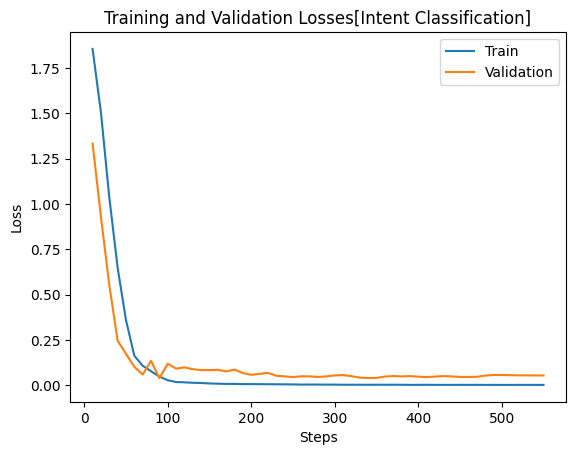

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Align losses
validation_steps = np.array(aligned_loss_callback.eval_steps)
train_losses = np.array(aligned_loss_callback.train_losses)
eval_losses = np.array(aligned_loss_callback.eval_losses)
print(len(validation_steps), len(train_losses), len(eval_losses))

# Plot aligned losses
plt.plot(validation_steps, train_losses, label='Train')
plt.plot(validation_steps, eval_losses, label='Validation')
plt.title('Training and Validation Losses[Intent Classification]')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./images/intent_losses.png')

In [5]:
# store the intent labels
import json
with open('./intent_model/intent_labels.json', 'w') as f:
    json.dump(intent_labels, f)

In [6]:
# Function to test the trained model
def test_model(input_text, model, tokenizer):
    # Tokenize the input text without 'token_type_ids'
    inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    
    # Remove 'token_type_ids' from the input if it exists
    inputs.pop('token_type_ids', None)
    
    # Move tensors to the appropriate device (GPU if available)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get predicted label (the class with the highest score)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=-1).item()
    
    return predicted_class_id

# Test the trained model with a sample input
input_text = "[INT] [BOT] [USR] Hey i want to know list my orders"
predicted_class_id = test_model(input_text, model, tokenizer)

# Print the predicted intent
print(f"Predicted intent ID: {predicted_class_id}")

# Optionally map the predicted intent ID back to the intent label
# get key from value
predicted_intent = list(intent_labels.keys())[list(intent_labels.values()).index(predicted_class_id)]
print(f"Predicted intent: {predicted_intent}")


Predicted intent ID: 2
Predicted intent: list_orders


In [7]:
# Load the model
# model = DistilBertForSequenceClassification.from_pretrained('./results/checkpoint-1500')

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Test the trained model with a sample input
input_text = "[INT] track_order [BOT] Please share the order ID [USR] 1231"
print(len(input_text))

# Get the predicted intent ID
predicted_class_id = test_model(input_text, model, tokenizer)

# Print the predicted intent
print(f"Predicted intent ID: {predicted_class_id}")
print(f"Predicted intent: {list(intent_labels.keys())[list(intent_labels.values()).index(predicted_class_id)]}")

# print probability scores of other intents
def get_intent_probs(input_text, model, tokenizer):
    # Tokenize the input text without 'token_type_ids'
    inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    
    # Remove 'token_type_ids' from the input if it exists
    inputs.pop('token_type_ids', None)
    
    # Move tensors to the appropriate device (GPU if available)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get predicted label (the class with the highest score)
    logits = outputs.logits
    probs = torch.softmax(logits, dim=-1)
    
    return probs

# Get the probability scores for all intents
probs = get_intent_probs(input_text, model, tokenizer)

test_df = pd.read_csv(datafile)
test_df = test_df[['instruction', 'intent']]

# randomly take 15 samples
test_df = test_df.sample(15)

# Get the predicted intent ID for each sample
test_df['predicted_intent_id'] = test_df['instruction'].apply(lambda x: test_model(x, model, tokenizer))

# Map the predicted intent ID back to the intent label
test_df['predicted_intent'] = test_df['predicted_intent_id'].apply(lambda x: list(intent_labels.keys())[list(intent_labels.values()).index(x)])

for idx, row in test_df.iterrows():
    print(f"Instruction: {row['instruction']}")
    print(f"True intent: {row['intent']}")
    print(f"Predicted intent: {row['predicted_intent']}")
    print('')


60
Predicted intent ID: 1
Predicted intent: give_order_id
Instruction: [INT] [BOT]  [USR] Can you check my order 12345?
True intent: track_order
Predicted intent: track_order

Instruction: [INT] cancel_order [BOT] Please confirm the cancellation of your last order. [USR] Yes, confirm it.
True intent: confirm_command
Predicted intent: confirm_command

Instruction: [INT] [BOT]  [USR] Cancel the last item I ordered.
True intent: cancel_order
Predicted intent: cancel_order

Instruction: [INT] give_order_id [BOT] Are you sure? [USR] Yes I am sure!
True intent: confirm_command
Predicted intent: confirm_command

Instruction: [INT] list_orders [BOT] Do you need to filter anything? [USR] Yeah give me just 32 of them
True intent: give_list_order_params
Predicted intent: give_list_order_params

Instruction: [INT] cancel_order [BOT] Can you confirm the cancellation of your most recent order? [USR] No, don’t proceed with it.
True intent: confirm_command
Predicted intent: confirm_command

Instructio

# NER

In [8]:
from transformers import BertTokenizerFast
from datasets import Dataset
import pandas as pd

# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
special_tokens = ["[INT]", "[BOT]", "[USR]"]
tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})


# Load the data
data = pd.read_csv('./data/ner_data.csv')
data["labels"] = data["labels"].apply(eval)

# Extract unique labels and create a mapping
unique_labels = sorted({label for labels in data["labels"] for label in labels})
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}

print("Label to ID Mapping:", label_to_id)

# Convert DataFrame to list of dictionaries for Dataset.from_list
data = data.to_dict(orient="records")

# Tokenize and align labels
def tokenize_and_align_labels(examples):
    # Tokenize the text
    tokenized_inputs = tokenizer(examples["instruction"], truncation=True, is_split_into_words=False)
    tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"])
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    label_ids = []
    labels = examples["labels"]

    # print(f"{'Token':<15} {'Word':<15} {'Label':<15}")

    for i, word_idx in enumerate(word_ids):
        token = tokens[i]  # Current token

        if word_idx is None:  # Special tokens ([CLS], [SEP], padding)
            word = "N/A"
            label = "Special"
            label_ids.append(-100)
        elif word_idx != previous_word_idx:  # First subword
            word = examples["instruction"][word_idx]
            label = labels[word_idx]
            label_ids.append(label_to_id[label])
        else:  # Subword token
            word = examples["instruction"][word_idx]
            label = labels[word_idx]
            token = f"Subword: {token} (Part of: {word})"
            label_ids.append(-100)

        # Print token, word, and label in the same line
        # print(f"{token:<15} {word:<15} {label:<15}")
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = label_ids
    return tokenized_inputs

# Convert to Hugging Face Dataset
dataset = Dataset.from_list(data)

# Map tokenizer to the dataset
dataset = dataset.map(tokenize_and_align_labels)


Label to ID Mapping: {'B-AFFIRMATION': 0, 'B-CONFIRMATION': 1, 'B-COUNT': 2, 'B-END_DATE': 3, 'B-ORD': 4, 'B-REASON': 5, 'B-START_DATE': 6, 'I-END_DATE': 7, 'I-REASON': 8, 'I-START_DATE': 9, 'O': 10}


Map: 100%|██████████| 104/104 [00:00<00:00, 7541.50 examples/s]


In [10]:
# store the label_to_id mapping
import json
import os
if not os.path.exists('./ner_model'):
    os.makedirs('./ner_model')
with open('./ner_model/entity_labels.json', 'w') as f:
    json.dump(label_to_id, f)

In [ ]:
from transformers import BertTokenizerFast, BertForTokenClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd

# Initialize tokenizer
# tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Load the data
data = pd.read_csv('./data/ner_data.csv')

# Convert stringified lists in 'labels' to actual lists
data["labels"] = data["labels"].apply(eval)

# Extract unique labels and create a mapping
unique_labels = sorted({label for labels in data["labels"] for label in labels})

# unique_labels = ['B-ORD', 'I-ORD', 'O']
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

print("Label to ID Mapping:", label_to_id)

# Convert DataFrame to list of dictionaries
data_dict = data.to_dict(orient="records")


# Tokenize and align labels

# Convert data to Hugging Face Dataset
hf_dataset = Dataset.from_list(data_dict)

# Split the dataset into train and validation sets
train_data, val_data = train_test_split(data_dict, test_size=0.1, random_state=42)
hf_dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "validation": Dataset.from_list(val_data),
})

# Apply the tokenizer and label alignment
hf_dataset = hf_dataset.map(tokenize_and_align_labels, batched=False)
# Define the model
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_to_id),
    id2label=id_to_label,
    label2id=label_to_id
)

model.resize_token_embeddings(len(tokenizer)) # need to test

# Define training arguments
training_args = TrainingArguments(
    output_dir="./ner_model",
    evaluation_strategy="steps",  # Perform evaluation at specific steps
    eval_steps=10,  # Log evaluation loss every 10 steps
    save_strategy="steps",
    save_steps=10,
    logging_steps=10,  # Log training loss every 10 steps
    learning_rate=1e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=100,
    weight_decay=0.0001,
    logging_dir="./logs",
    save_total_limit=2,
    load_best_model_at_end=True
)


# Use default data collator for token classification
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_dataset["train"],
    eval_dataset=hf_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[aligned_loss_callback]
)

# Train the model
trainer.train()

# Save the model and tokenizer
model.save_pretrained("./ner_model")
tokenizer.save_pretrained("./ner_model")


Label to ID Mapping: {'B-AFFIRMATION': 0, 'B-CONFIRMATION': 1, 'B-COUNT': 2, 'B-END_DATE': 3, 'B-ORD': 4, 'B-REASON': 5, 'B-START_DATE': 6, 'I-END_DATE': 7, 'I-REASON': 8, 'I-START_DATE': 9, 'O': 10}


Map: 100%|██████████| 11/11 [00:00<00:00, 2816.86 examples/s]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/home/harshit/IITH/Sem7/CyberSecurityAndAI/project/cyber_security_project/venv/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_29223/2903455539.py:76: FutureWarning: `tokenizer` is deprecated and will be removed

{'loss': 1.939, 'grad_norm': 11.833813667297363, 'learning_rate': 9.97872340425532e-06, 'epoch': 0.21}



  0%|          | 10/4700 [00:00<04:42, 16.60it/s]

{'eval_loss': 1.252511978149414, 'eval_runtime': 0.0261, 'eval_samples_per_second': 420.735, 'eval_steps_per_second': 229.492, 'epoch': 0.21}


  0%|          | 20/4700 [00:02<09:03,  8.61it/s]

{'loss': 0.8872, 'grad_norm': 5.8260498046875, 'learning_rate': 9.957446808510639e-06, 'epoch': 0.43}



  0%|          | 20/4700 [00:02<09:03,  8.61it/s]

{'eval_loss': 0.38449764251708984, 'eval_runtime': 0.0237, 'eval_samples_per_second': 463.161, 'eval_steps_per_second': 252.633, 'epoch': 0.43}


  1%|          | 30/4700 [00:04<09:29,  8.20it/s]

{'loss': 0.5857, 'grad_norm': 2.212134838104248, 'learning_rate': 9.936170212765958e-06, 'epoch': 0.64}



  1%|          | 30/4700 [00:04<09:29,  8.20it/s]

{'eval_loss': 0.3017134666442871, 'eval_runtime': 0.0262, 'eval_samples_per_second': 420.359, 'eval_steps_per_second': 229.287, 'epoch': 0.64}


  1%|          | 40/4700 [00:07<10:13,  7.60it/s]

{'loss': 0.3203, 'grad_norm': 3.0291926860809326, 'learning_rate': 9.914893617021277e-06, 'epoch': 0.85}



  1%|          | 40/4700 [00:07<10:13,  7.60it/s]

{'eval_loss': 0.25034913420677185, 'eval_runtime': 0.0287, 'eval_samples_per_second': 383.124, 'eval_steps_per_second': 208.977, 'epoch': 0.85}


  1%|          | 50/4700 [00:09<10:28,  7.40it/s]

{'loss': 0.3041, 'grad_norm': 1.6541122198104858, 'learning_rate': 9.893617021276596e-06, 'epoch': 1.06}



  1%|          | 50/4700 [00:09<10:28,  7.40it/s]

{'eval_loss': 0.20666584372520447, 'eval_runtime': 0.0264, 'eval_samples_per_second': 417.419, 'eval_steps_per_second': 227.683, 'epoch': 1.06}


  1%|▏         | 60/4700 [00:12<11:33,  6.69it/s]

{'loss': 0.5544, 'grad_norm': 7.551794052124023, 'learning_rate': 9.872340425531915e-06, 'epoch': 1.28}



  1%|▏         | 60/4700 [00:12<11:33,  6.69it/s]

{'eval_loss': 0.17982688546180725, 'eval_runtime': 0.026, 'eval_samples_per_second': 423.007, 'eval_steps_per_second': 230.731, 'epoch': 1.28}


  1%|▏         | 70/4700 [00:14<12:00,  6.43it/s]

{'loss': 0.2043, 'grad_norm': 1.3758814334869385, 'learning_rate': 9.851063829787235e-06, 'epoch': 1.49}



  1%|▏         | 70/4700 [00:14<12:00,  6.43it/s]

{'eval_loss': 0.16369609534740448, 'eval_runtime': 0.0277, 'eval_samples_per_second': 397.671, 'eval_steps_per_second': 216.911, 'epoch': 1.49}


55 525 525


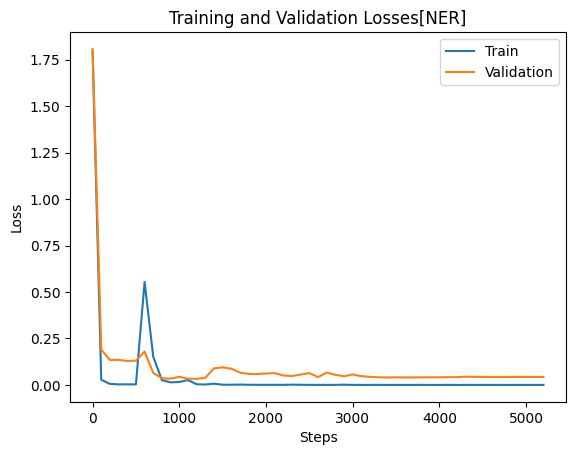

In [38]:
# plot the losses
import numpy as np

# Align losses
steps = [i*10 for i in range(len(aligned_loss_callback.train_losses))]
train_losses = np.array(aligned_loss_callback.train_losses)

eval_losses = np.array(aligned_loss_callback.eval_losses)
print(len(validation_steps), len(train_losses), len(eval_losses))

# Plot aligned losses
plt.plot(steps[::10], train_losses[::10], label='Train')
plt.plot(steps[::10], eval_losses[::10], label='Validation')

plt.title('Training and Validation Losses[NER]')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./images/ner_losses.png')

In [39]:
# copy model to backend
import shutil

shutil.rmtree(target_dir, ignore_errors=True)
shutil.copytree('./ner_model', target_dir)

'../backend/chatbot/'

In [40]:
from transformers import BertTokenizerFast, BertForTokenClassification
import torch

# Load the saved model and tokenizer
# model_dir = "./ner_model"
# tokenizer = BertTokenizerFast.from_pretrained(model_dir)
# model = BertForTokenClassification.from_pretrained(model_dir)

# Load the label mappings
id_to_label = model.config.id2label

# Sample text to test the model
test_sentences = [
    "[INT] [BOT]  [USR] Order 121435, whats the status?"
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict_ner(sentence):
    # Tokenize the sentence
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    # print(inputs)

    # Get model predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract logits and compute predictions
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=2)

    # Map predictions to labels
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    predicted_labels = [id_to_label[pred.item()] for pred in predictions[0]]

    # Combine tokens and predicted labels
    results = []
    for token, label in zip(tokens, predicted_labels):
        if token not in ["[CLS]", "[SEP]", "[PAD]"]:  # Ignore special tokens
            results.append((token, label))
    return results

# Test the model with sample sentences
for sentence in test_sentences:
    # print(f"Sentence: {sentence}")
    predictions = predict_ner(sentence)
    # print("Predictions:")
    # for token, label in predictions:
        # print(f"{token:15} -> {label}")
    # print("\n")

def extract_entity(sentence, entity_label):
    """
    enitity_label: the label of the entity to extract (ORD for example)
    extract the entity from the sentence along with I-ORD tokens
    """
    # Get NER predictions
    predictions = predict_ner(sentence)
    # for token, label in predictions:
    #     # print(f"{token:15} -> {label}")

    # get all entities in the label
    all_entities = []
    for token, label in predictions:
        if label.startswith("B-") or label.startswith("I-"):
            all_entities.append(label.split("-")[1])

    all_entities = list(set(all_entities))

    return_values = []
    for entity_label in all_entities:
        # Extract entities with the specified label
        entities = []
        for token, label in predictions:
            if label == f"B-{entity_label}" or label == f"I-{entity_label}":
                entities.append(token)
        # print(entities)
        
        # remove subword prefixes from the entities
        entity_combined = []
        prev_entity = None
        for i , entity in enumerate(entities):
            if entity.startswith("##"):
                if prev_entity is None:
                    prev_entity = ""
                prev_entity += entity[2:]
            else:
                if prev_entity:
                    entity_combined.append(prev_entity)
                prev_entity = entity

            if i == len(entities) - 1:
                entity_combined.append(prev_entity)
        return_values.append((entity_label, entity_combined))
    return return_values
        

# get the B-COUNT entity from the sentence
sentence = "[INT] [BOT]  [USR] Please show me a list of all the orders I've made before 21 November 2024 and after 10 April 2024"
entity_label = "START_DATE"
extracted_entity = extract_entity(sentence, entity_label)
print(f"Extracted entity: {extracted_entity}")

Extracted entity: [('START_DATE', ['10', 'april', '202']), ('END_DATE', ['21', 'november', '2024'])]


In [41]:
# test for 15 random samples
data = pd.read_csv('./data/ner_data.csv')

# draw 15 random samples
test_data = data.sample(15)

for idx, row in test_data.iterrows():
    print(f"Sentence: {row['instruction']}")
    # get the 
    extracted_entity = extract_entity(row['instruction'], "ORD")
    print(f"Extracted entity: {extracted_entity}")
    print("")

Sentence: [INT] [BOT]  [USR] Can you check my order 12345?
Extracted entity: [('ORD', ['12345'])]

Sentence: [INT] cancel_order [BOT] Please confirm the cancellation of your last order. [USR] Yes, confirm it.
Extracted entity: [('CONFIRMATION', ['yes'])]

Sentence: [INT] [BOT]  [USR] Cancel the last item I ordered.
Extracted entity: [('ORD', ['last'])]

Sentence: [INT] give_order_id [BOT] Are you sure? [USR] Yes I am sure!
Extracted entity: [('AFFIRMATION', ['yes'])]

Sentence: [INT] list_orders [BOT] Do you need to filter anything? [USR] Yeah give me just 32 of them
Extracted entity: [('COUNT', ['32'])]

Sentence: [INT] cancel_order [BOT] Can you confirm the cancellation of your most recent order? [USR] No, don’t proceed with it.
Extracted entity: [('AFFIRMATION', ['no'])]

Sentence: [INT] cancel_order [BOT] Are you sure you want to cancel order 112233? [USR] No, leave it as is.
Extracted entity: [('AFFIRMATION', ['no'])]

Sentence: [INT] [BOT]  [USR] Can you list some of my previous 